In [2]:
import shap
import torch
from model import model as module_model
import torch.nn as nn
import pandas as pd
import dataset
from mytransform import MeanStdNormalize, MinMaxNormalize, MeanStdDeNormalize, MinMaxDeNormalize, LogNormalize, LogDeNormalize
import json
import numpy as np
import ipywidgets as widgets
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
np.random.seed(42)
shap.initjs()

Reference: https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/model_agnostic/Multioutput%20Regression%20SHAP.html#Get-SHAP-Values-and-Plots

# Prepare args

In [3]:
# config = "saved_deepOnetC_31/models/Mnist_LeNet/0625_143733/config.json"
# state_path = "saved_deepOnetC_31/models/Mnist_LeNet/0625_143733/checkpoint-epoch200.pth"
# state_path = "saved_deepOnetC_31/models/Mnist_LeNet/0625_143733/best_target_state_dict.pth"
config = "saved_deepOnetC_5/models/Mnist_LeNet/0701_041015/config.json"
state_path = "saved_deepOnetC_5/models/Mnist_LeNet/0701_041015/best_target_state_dict.pth"

config = json.load(open(config))
# config = ConfigParser.from_args(args)


# Prepare Models

In [4]:
def init_obj(config, name, module, *args, **kwargs):
    module_name = config[name]['type']
    module_args = dict(config[name]['args'])
    assert all([k not in module_args for k in kwargs]), 'Overwriting kwargs given in config file is not allowed'
    
    module_args.update(kwargs)
    return getattr(module, module_name)(*args, **module_args)

activation = getattr(nn, config["activation"])
trunk = init_obj(config, 'trunk', module_model, activation=activation)
branch = init_obj(config, 'branch', module_model, activation=activation)
z_net = init_obj(config, 'z_net', module_model, activation=activation)

if config['arch_name'] == 'TriDeepONet':
    model = module_model.TriDeepONet(trunk, branch, z_net)
elif config['arch_name'] == 'DeepONet':
    model = module_model.DeepONet(trunk, branch)
model = model.cuda()
# model.load_state_dict(torch.load(state_path)['state_dict'])
model.load_state_dict(torch.load(state_path)[5])
model = model.eval()

In [5]:
split_dict = {
    "ClimateDatasetV2A": "split_datesA.txt",
    "ClimateDatasetV2B": "split_datesB.txt",
    "ClimateDatasetV2C": "split_datesC.txt",
}
train_dates, test_dates = [], []
split_path = split_dict[config['dataset']]
with open(os.path.join("../climate_washed", split_path)) as f:
    for line in f.readlines():
        date, mode = line.split(" ")
        date = date.strip()
        mode = mode.strip()
        
        if mode == 'train':
            train_dates.append(date)
        elif mode == 'test':
            test_dates.append(date)

# Prepare Data

In [6]:
data_class = getattr(dataset, config['dataset'])
trainset = data_class("../climate_washed", config['normalize'], split="train", x_feature=config['x_feature'], y_feature=config['y_feature'])
stats = trainset.get_stats()
testset = data_class("../climate_washed", config['normalize'], split="test", stats=stats, x_feature=config['x_feature'], y_feature=config['y_feature'])


(206966, 20)


In [40]:
from torch import from_numpy
test_target = testset.targets
test_station, test_target, test_temporal = [], [], []

for idx, targets in enumerate(testset.targets):
    station = testset.stations[idx]
    target = testset.targets[idx]
    temporal = testset.temporal[idx]
    test_station.append(station)
    test_target.append(target)
    test_temporal.append(temporal)

test_station = from_numpy(np.concatenate(test_station))
test_target = from_numpy(np.concatenate(test_target))
test_temporal = from_numpy(np.concatenate(test_temporal))
print(test_station.shape, test_target.shape, test_temporal.shape)

for i in range(10, 21):
    print(i,",", ((~torch.isnan(test_target)).sum(dim=1)==i).sum().item())

# find the index where (~torch.isnan(target)).sum(dim=1)==20
test_valid_index = ((~torch.isnan(test_target)).sum(dim=1)>=15).nonzero().squeeze()
print(test_valid_index.shape)


torch.Size([48774, 5]) torch.Size([48774, 20]) torch.Size([48774, 25])
10 , 2289
11 , 2085
12 , 1908
13 , 1399
14 , 727
15 , 818
16 , 544
17 , 743
18 , 1460
19 , 1293
20 , 1411
torch.Size([6269])


In [7]:
target = trainset.targets
print(target.shape)
print("Valid y number, count")
for i in range(10, 21):
    print(i,",", ((~torch.isnan(target)).sum(dim=1)==i).sum().item())

# find the index where (~torch.isnan(target)).sum(dim=1)==20
valid_index = ((~torch.isnan(target)).sum(dim=1)>=19).nonzero().squeeze()
print(valid_index.shape)


torch.Size([206966, 20])
Valid y number, count
10 , 10767
11 , 9157
12 , 8097
13 , 5834
14 , 3869
15 , 3807
16 , 2231
17 , 3236
18 , 6084
19 , 5473
20 , 6762
torch.Size([12235])


In [8]:
if config['normalize'] == "MinMaxNormalize":
    temporal_transform = MinMaxNormalize(
        stats['temporal']['max'],
        stats['temporal']['min']
    )
    station_transform = MinMaxNormalize(
        stats['station']['max'],
        stats['station']['min']
    )
elif config['normalize'] == "MeanStdNormalize":
    temporal_transform = MeanStdNormalize(
        stats['temporal']['mean'],
        stats['temporal']['variance']
    )
    station_transform = MeanStdNormalize(
        stats['station']['mean'],
        stats['station']['variance']
    )
target_transform = LogNormalize(
    stats['target']['10th'],
    stats['target']['90th']
)
target_detransform = LogDeNormalize(
    stats['target']['10th'],
    stats['target']['90th']
)

# Kernel Explainer

In [8]:
def predict(x: np.ndarray):
    temporal = x[:, :len(config['x_feature'])].astype(np.float32)
    station = x[:, len(config['x_feature']):].astype(np.float32)
    
    temporal = torch.from_numpy(temporal)
    station = torch.from_numpy(station)
    
    temporal = temporal_transform(temporal).cuda()
    station = station_transform(station).cuda()
    
    prediction = model(temporal, station)
    prediction = target_detransform(prediction)
    
    prediction_df = pd.DataFrame(prediction.cpu().detach().numpy(), columns=[config['y_feature']])
    return prediction_df

In [99]:
stations, temporal = trainset.stations, trainset.temporal
train_data = torch.cat([temporal, stations], dim=1)

train_data = train_data[valid_index].numpy()
# randomly select 5000 samples from train data
indices = np.random.choice(train_data.shape[0], 400, replace=False)
# train_data = train_data[indices].numpy()
train_data = train_data[indices]

In [9]:
station_id = "01054200"

temporal_df = pd.read_csv(f"../climate_washed/{station_id}.csv")
stations = pd.read_csv(f"../climate_washed/static_filtered.csv", dtype={"STAID": str})
stations["STAID"] = stations["STAID"].apply(lambda x: str(x).zfill(8))
station_df = stations[stations["STAID"] == station_id].iloc[:, 1:]

# load train data
train_temporal_df = temporal_df[temporal_df['Date'].isin(train_dates)].reset_index(drop=True)
train_temporal_df = train_temporal_df[config['x_feature']]
station_df_broadcast = pd.DataFrame(np.repeat(station_df.values, train_temporal_df.shape[0], axis=0))
station_df_broadcast.columns = station_df.columns

# train_df = pd.concat([train_temporal_df, station_df_broadcast], axis=1)
train_df = train_temporal_df.join(station_df_broadcast)
# print(train_temporal_df.head)
# print(station_df_broadcast.head)
# print(train_df.head)


# load test data
test_temporal_df = temporal_df[temporal_df['Date'].isin(test_dates)].reset_index(drop=True)
test_temporal_df = test_temporal_df[config['x_feature']]
station_df_broadcast = pd.DataFrame(np.repeat(station_df.values, test_temporal_df.shape[0], axis=0))
station_df_broadcast.columns = station_df.columns
# test_df = pd.concat([test_temporal_df, station_df_broadcast], axis=1)
test_df = test_temporal_df.join(station_df_broadcast)
# print(test_temporal_df.shape)
# print(station_df_broadcast.shape)
# print(test_df.shape)

In [11]:
# explainer = shap.KernelExplainer(predict, train_df)
print(train_data.shape)
explainer = shap.KernelExplainer(predict, train_data)


Using 500 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


(500, 105)


In [13]:
shap_values = explainer.shap_values(train_data, nsamples=200)
# shap_values = explainer(train_data)


  0%|          | 0/400 [00:00<?, ?it/s]

In [14]:
list_of_labels = config['y_feature']

# Create a list of tuples so that the index of the label is what is returned
tuple_of_labels = list(zip(list_of_labels, range(len(list_of_labels))))

# Create a widget for the labels and then display the widget
current_label = widgets.Dropdown(
    options=tuple_of_labels, value=0, description="Select Label:"
)

# Display the dropdown list (Note: access index value with 'current_label.value')
current_label

Dropdown(description='Select Label:', options=(('00010', 0), ('00095', 1), ('00300', 2), ('00400', 3), ('00405…

In [ ]:
mean = shap_values[:, :, current_label.value].mean(0)

# pair the mean with test_df.columns, then rank them in descending order of absolute value
mean = pd.Series(mean, index=test_df.columns)
mean = mean.abs().sort_values(ascending=True)


# bar plot the mean impact of each feature, the bar names are the feature names
# plot the top 40 features only
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 20))
mean.plot(kind='barh')

plt.show()


In [ ]:
print(f"Current Label Shown: {list_of_labels[current_label.value]}\n")

# shap.plots.violin(
#     # shap_values[:, :, current_label.value], 
#     shap_values,
#     feature_names=test_df.columns,
#     max_display=41
# )
shap.summary_plot(
    shap_values,
    # shap_values[:, :, current_label.value], 
    features=test_df.columns
)

# Deep Explainer

In [10]:
class TriDeepExplain(module_model.TriDeepONet):
    def forward(self, x):
        if isinstance(x, np.ndarray):
            x = torch.from_numpy(x).float().cuda()
        u = x[:, :len(config['x_feature'])]
        y = x[:, len(config['x_feature']):]

        u_out = self.u_net(u)
        # u_out = F.dropout(u_out, p=0.25)
        y_out = self.y_net(y)
        # y_out = F.dropout(y_out, p=0.25)
        outputs = u_out * y_out
        #outputs = F.dropout(outputs, p=0.25)
        outputs = self.z_net(outputs)

        # return target_detransform(outputs)
        return outputs

class DeepExplain(module_model.DeepONet):
    def forward(self, x):
        if isinstance(x, np.ndarray):
            x = torch.from_numpy(x).float().cuda()
        u = x[:, :len(config['x_feature'])]
        y = x[:, len(config['x_feature']):]

        u_out = self.u_net(u)
        y_out = self.y_net(y)

        outputs = torch.sum(u_out * y_out, dim=-1)
        # return target_detransform(outputs)
        return outputs

In [11]:
activation = getattr(nn, config["activation"])
trunk = init_obj(config, 'trunk', module_model, activation=activation)
branch = init_obj(config, 'branch', module_model, activation=activation)
z_net = init_obj(config, 'z_net', module_model, activation=activation)

if config['arch_name'] == 'TriDeepONet':
    model = TriDeepExplain(trunk, branch, z_net)
elif config['arch_name'] == 'DeepONet':
    model = DeepExplain(trunk, branch)

model = model.cuda()
model.load_state_dict(torch.load(state_path)[9])
model = model.eval()

In [49]:
test_data = torch.cat([test_temporal, test_station], dim=1).float()
test_data = test_data[test_valid_index].numpy()

indices = np.random.choice(test_data.shape[0], 4500, replace=False)
test_data = test_data[indices]
print(test_data.shape)

(4500, 30)


In [42]:
stations, temporal = trainset.stations, trainset.temporal
stations = station_transform(stations)
temporal = temporal_transform(temporal)
train_data = torch.cat([temporal, stations], dim=1)

# randomly select 5000 samples from train data
train_data = train_data[valid_index].numpy()
indices = np.random.choice(train_data.shape[0], 10000, replace=False)
# train_data = train_data[indices].numpy()
train_data = train_data[indices]
print(train_data.shape)

(10000, 30)


In [50]:
# convert train df to pytorch tensor
# train_data = torch.from_numpy(train_df.values).float().cuda()

deep_explainer = shap.DeepExplainer(
    model,
    torch.from_numpy(train_data).cuda(),
)

In [51]:
deep_shap_values = deep_explainer.shap_values(
    # torch.from_numpy(train_data).cuda(),
    torch.from_numpy(test_data).cuda(), 
    check_additivity=False
)

In [52]:
list_of_labels = config['y_feature']

# Create a list of tuples so that the index of the label is what is returned
tuple_of_labels = list(zip(list_of_labels, range(len(list_of_labels))))

# Create a widget for the labels and then display the widget
current_label = widgets.Dropdown(
    options=tuple_of_labels, value=0, description="Select Label:"
)

# Display the dropdown list (Note: access index value with 'current_label.value')
current_label

Dropdown(description='Select Label:', options=(('00010', 0), ('00095', 1), ('00300', 2), ('00400', 3), ('00405…

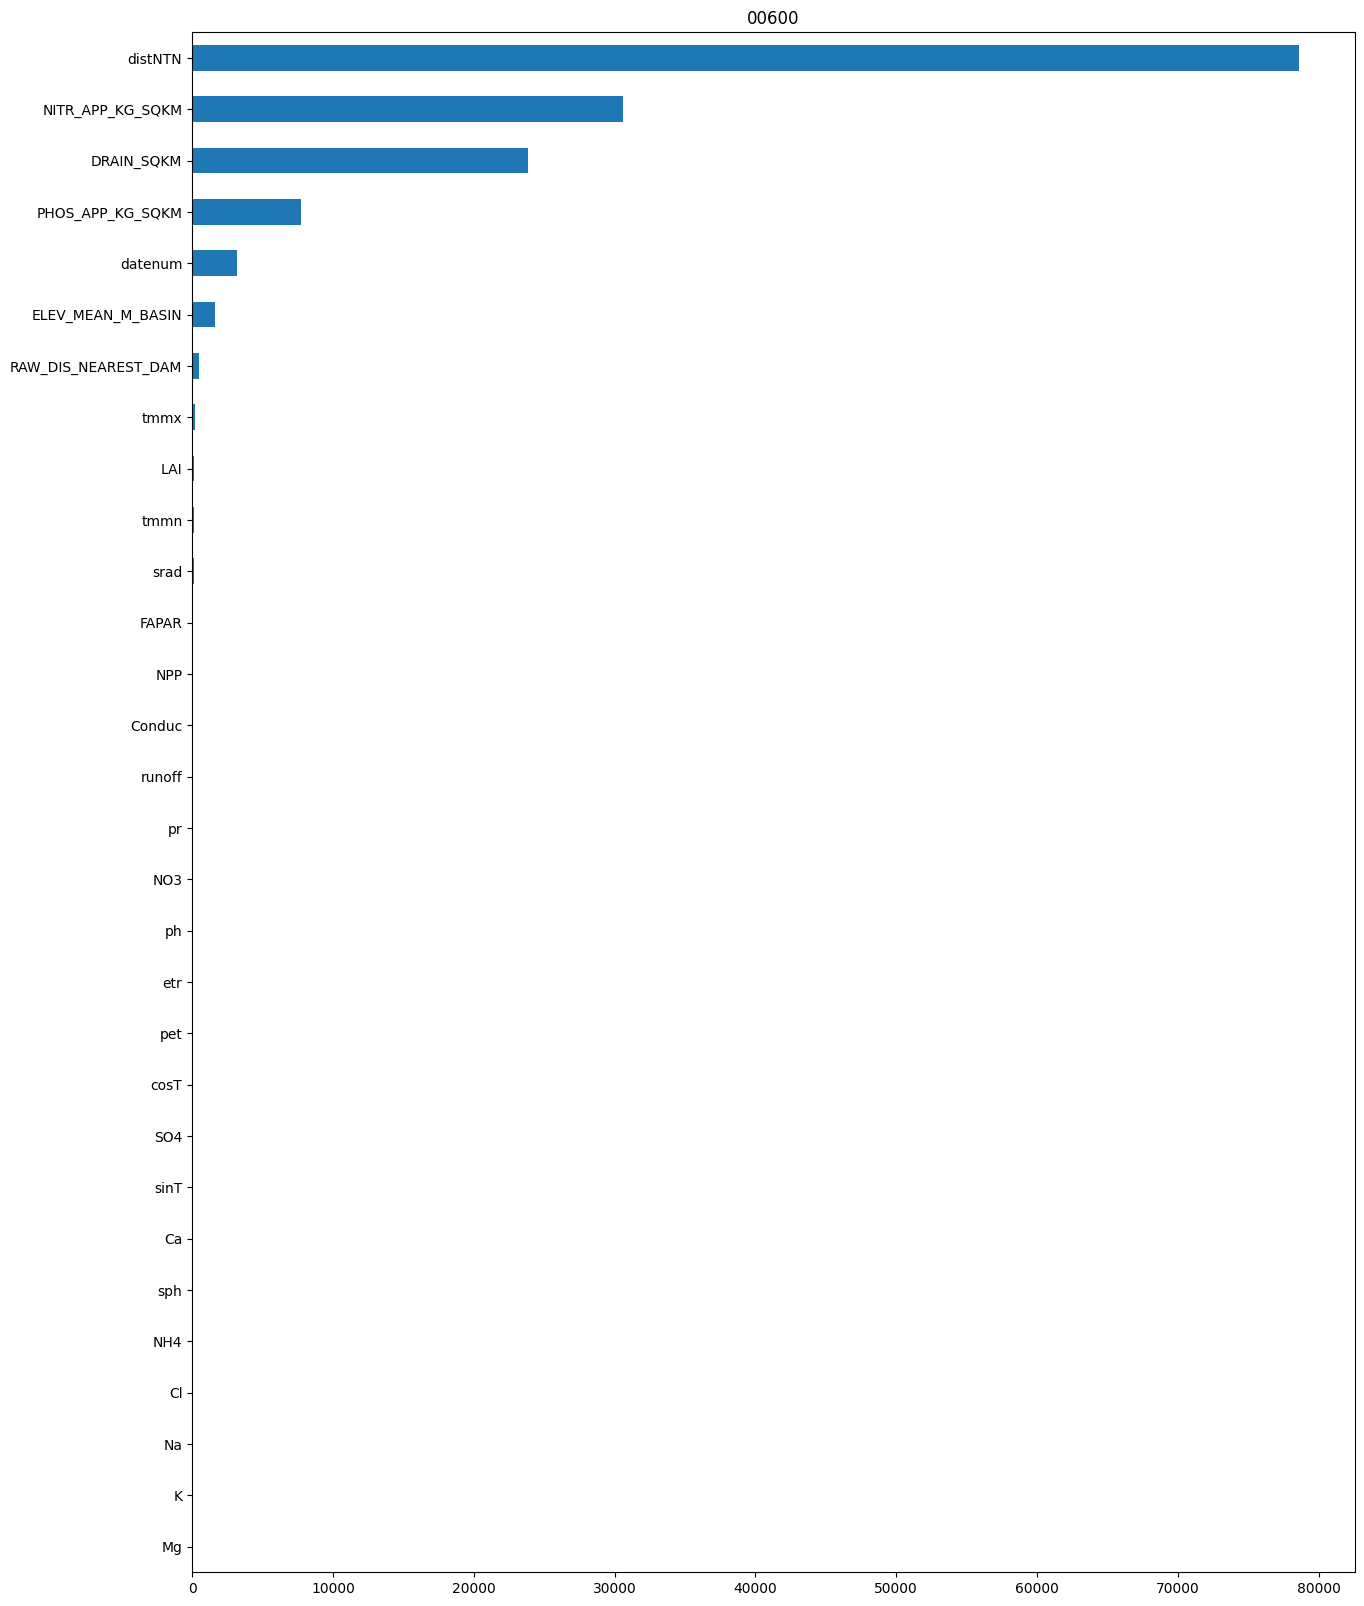

In [57]:

# for i in range(20):
#     deep_mean = deep_shap_values[:, :, i].mean(0)

#     # pair the mean with test_df.columns, then rank them in descending order of absolute value
#     deep_mean = pd.Series(deep_mean, index=test_df.columns)
#     deep_mean = deep_mean.abs().sort_values(ascending=True)

#     # bar plot the mean impact of each feature, the bar names are the feature names
#     # plot in descending order
#     import matplotlib.pyplot as plt
#     plt.figure(figsize=(15, 20))
#     deep_mean.plot(kind='barh')
#     plt.title(config['y_feature'][i])
#     plt.savefig("shap_plot/"+config['y_feature'][i]+".png")
deep_mean = np.abs(deep_shap_values[:, :, current_label.value]).mean(0)

# pair the mean with test_df.columns, then rank them in descending order of absolute value
deep_mean = pd.Series(deep_mean, index=test_df.columns)
deep_mean = deep_mean.abs().sort_values(ascending=True)

# bar plot the mean impact of each feature, the bar names are the feature names
# plot in descending order
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 20))
deep_mean.plot(kind='barh')
plt.title(config['y_feature'][current_label.value])
plt.show()


Current Label Shown: 00665



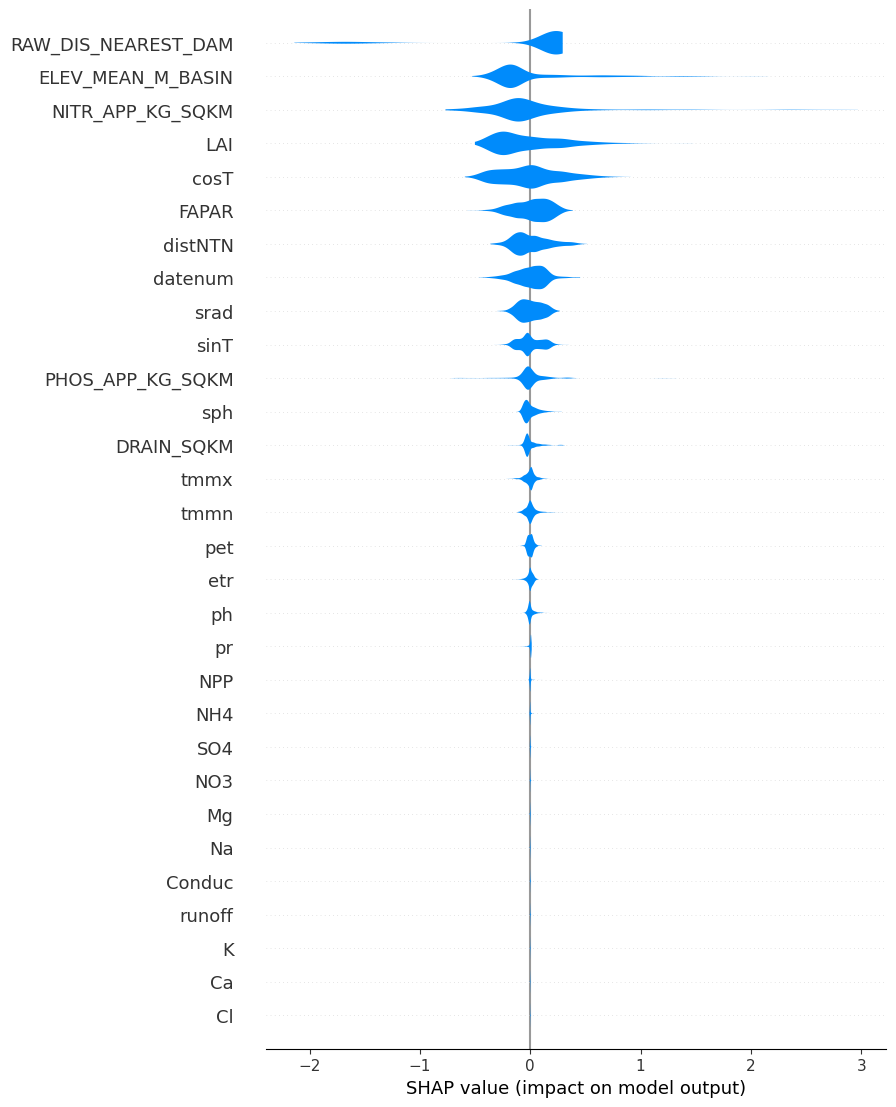

In [22]:
print(f"Current Label Shown: {list_of_labels[current_label.value]}\n")

shap.plots.violin(
    deep_shap_values[:, :, current_label.value], 
    feature_names=test_df.columns,
    max_display=105
)
# shap.summary_plot(
#     deep_shap_values[:, :, current_label.value], features=test_df.columns
# )

In [40]:
np.save("shap_value_6000.npy", deep_shap_values)

In [36]:
shap.plots.bar(
    deep_shap_values[:, :, current_label.value],
    max_display=30,
    
)

TypeError: The shap_values argument must be an Explanation object, Cohorts object, or dictionary of Explanation objects!

# LIME

In [9]:
class TriDeepExplain(module_model.TriDeepONet):
    def forward(self, x):
        if isinstance(x, np.ndarray):
            x = torch.from_numpy(x).float().cuda()
        u = x[:, :len(config['x_feature'])]
        y = x[:, len(config['x_feature']):]

        u_out = self.u_net(u)
        # u_out = F.dropout(u_out, p=0.25)
        y_out = self.y_net(y)
        # y_out = F.dropout(y_out, p=0.25)
        outputs = u_out * y_out
        #outputs = F.dropout(outputs, p=0.25)
        outputs = self.z_net(outputs)[..., 9]

        # return target_detransform(outputs)
        return outputs.detach().cpu().numpy()

class DeepExplain(module_model.DeepONet):
    def forward(self, x):
        if isinstance(x, np.ndarray):
            x = torch.from_numpy(x).float().cuda()
        u = x[:, :len(config['x_feature'])]
        y = x[:, len(config['x_feature']):]

        u_out = self.u_net(u)
        y_out = self.y_net(y)

        outputs = torch.sum(u_out * y_out, dim=-1).detach().cpu().numpy()
        # return target_detransform(outputs)
        return outputs
    
activation = getattr(nn, config["activation"])
trunk = init_obj(config, 'trunk', module_model, activation=activation)
branch = init_obj(config, 'branch', module_model, activation=activation)
z_net = init_obj(config, 'z_net', module_model, activation=activation)

if config['arch_name'] == 'TriDeepONet':
    model = TriDeepExplain(trunk, branch, z_net)
elif config['arch_name'] == 'DeepONet':
    model = DeepExplain(trunk, branch)

model = model.cuda()
model.load_state_dict(torch.load(state_path)[9])
model = model.eval()

In [10]:
import lime
import lime.lime_tabular
stations, temporal = trainset.stations, trainset.temporal
train_data = torch.cat([temporal, stations], dim=1)

train_data = train_data[valid_index].numpy()
# train_data = train_data.numpy()

# randomly select 5000 samples from train data
indices = np.random.choice(train_data.shape[0], 100000, replace=False)
# train_data = train_data[indices].numpy()
train_data = train_data[indices]
print(train_data.shape)

(100000, 105)


In [15]:
lime_explainer = lime.lime_tabular.LimeTabularExplainer(train_data, feature_names=test_df.columns, mode="regression")

In [16]:
from tqdm import tqdm
num = 100000
values = np.zeros([num, train_data.shape[1]])

for i in tqdm(range(num)):
    exp = lime_explainer.explain_instance(train_data[i], model.forward, num_features=train_data.shape[1])
    result = exp.as_map()[0]
    for key, value in result:
        values[i, key] = value
    

100%|██████████| 100000/100000 [7:04:32<00:00,  3.93it/s] 


In [1]:
# exp.show_in_notebook(show_table=True)
exp.show_in_notebook()


NameError: name 'exp' is not defined

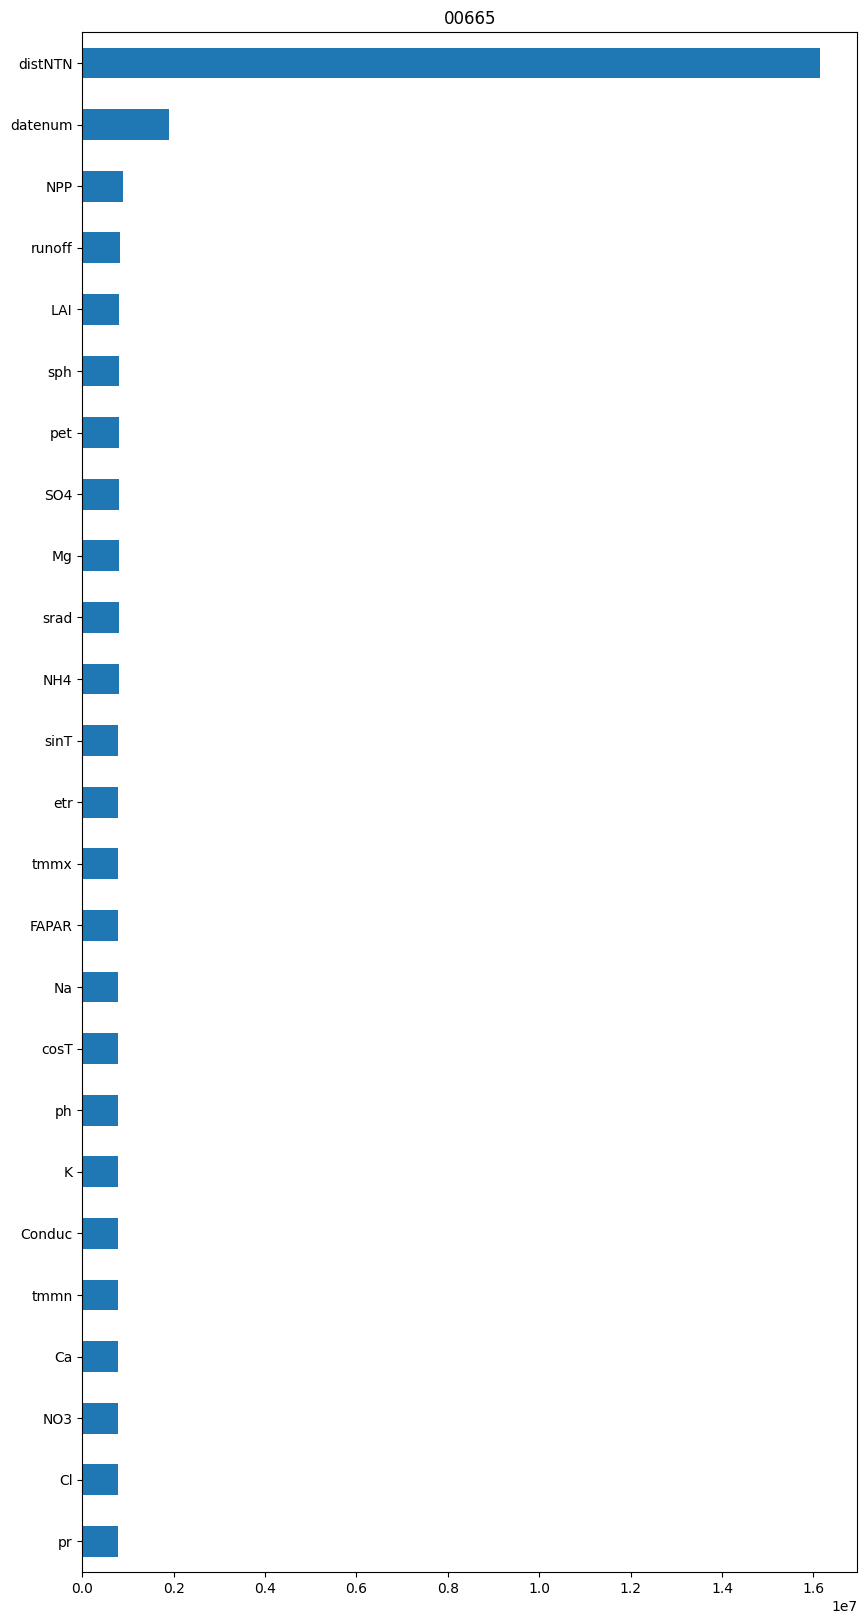

In [18]:
means = np.abs(values).mean(axis=0)
# pair the means with test_df.columns, then rank them in descending order of absolute value
means = pd.Series(means, index=test_df.columns)
means = means.abs().sort_values(ascending=True)
# find the rows where index is in config['x_feature']
means = means.loc[config['x_feature']].sort_values(ascending=True)

# plot the mean impact of each feature, the bar names are the feature names
# plot in descending order
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 20))
means.plot(kind='barh')
plt.title("00665")
plt.show()